Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CGAN Implementation

In [26]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

## Generated Image folder

In [16]:
os.makedirs("images", exist_ok=True)
print(">>> Making images directory...")

>>> Making images directory...


## Hyper-parameter setting

In [17]:
import easydict as parser
 
opt = parser.EasyDict({
        "n_epochs": 200,
        "batch_size": 64, 
        "lr": 0.0002,
        "b1": 0.5,
        "b2": 0.999,
        "n_cpu": 8,
        "latent_dim": 100,
        "n_classes": 10,
        "img_size": 224,
        "channels": 1,
        "sample_interval": 400.
})

img_shape = (opt.channels, opt.img_size, opt.img_size)
print(">>> Image shape:", img_shape)
cuda = True if torch.cuda.is_available() else False
print(">>> GPU Usage:", cuda)

>>> Image shape: (1, 224, 224)
>>> GPU Usage: True


## Dataloader

In [18]:
# Configure data loader
os.makedirs("data/mnist", exist_ok=True)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    drop_last=True, ### ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256])
    shuffle=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [39]:
dataloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

class: 7


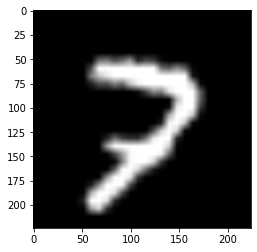

In [69]:
for images, labels in dataloader:  
    sample_image = images[0]    
    sample_label = labels[0]
    break

print("class:", sample_label.item())
plt.imshow(sample_image.reshape(224, 224), cmap='gray')
plt.show()

## Saving sample image func

In [19]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    labels = F.one_hot(labels, num_classes=10) ### One hot encoding
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

## Generator Class

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        #self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes) ### One hot encoding

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        #gen_input = torch.cat((self.label_emb(labels), noise), -1)
        gen_input = torch.cat((labels, noise), -1) ### One hot encoding

        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

## Discriminator Class

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        #self.label_embedding = nn.Embedding(opt.n_classes, opt.n_classes) ### One hot encoding

        self.model = nn.Sequential(
            nn.Linear(opt.n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        #d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        d_in = torch.cat((img.view(img.size(0), -1), labels), -1) ### One hot encoding
        validity = self.model(d_in)
        
        return validity

## Loss function and Initializing Model

In [22]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss functions
adversarial_loss = torch.nn.MSELoss()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

## Optimizers

In [23]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

## Training

In [24]:
# ----------
#  Training
# ----------

### Generator and Discriminator Losses
G_losses = []
D_losses = []

for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))
        labels = F.one_hot(labels, num_classes=10) ### One hot encoding

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size))) ### ?????
        gen_labels = F.one_hot(gen_labels, num_classes=10) ### One hot encoding
        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)

        ### Loss check
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[Epoch 194/200] [Batch 622/937] [D loss: 0.158661] [G loss: 0.533430]
[Epoch 194/200] [Batch 623/937] [D loss: 0.162016] [G loss: 0.585834]
[Epoch 194/200] [Batch 624/937] [D loss: 0.181592] [G loss: 0.340294]
[Epoch 194/200] [Batch 625/937] [D loss: 0.161524] [G loss: 0.458122]
[Epoch 194/200] [Batch 626/937] [D loss: 0.178742] [G loss: 0.484670]
[Epoch 194/200] [Batch 627/937] [D loss: 0.204066] [G loss: 0.348989]
[Epoch 194/200] [Batch 628/937] [D loss: 0.180285] [G loss: 0.480817]
[Epoch 194/200] [Batch 629/937] [D loss: 0.206029] [G loss: 0.433997]
[Epoch 194/200] [Batch 630/937] [D loss: 0.202703] [G loss: 0.374428]
[Epoch 194/200] [Batch 631/937] [D loss: 0.189423] [G loss: 0.493293]
[Epoch 194/200] [Batch 632/937] [D loss: 0.180077] [G loss: 0.422617]
[Epoch 194/200] [Batch 633/937] [D loss: 0.152530] [G loss: 0.519276]
[Epoch 194/200] [Batch 634/937] [D loss: 0.165741] [G loss: 0.405422]
[Epoch 194/200] [Batch 635/937] [D loss: 0.158471] [G 

## Generator and Discriminator Loss Plot

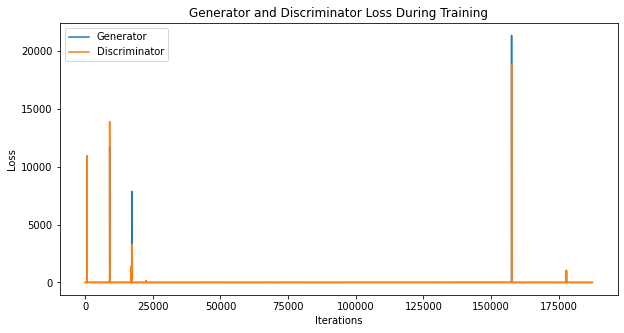

In [27]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Save Model

In [28]:
torch.save(generator.state_dict(), 'generator_mnist_ver2.pth')

## Loading trained Model

In [29]:
trained_generator = Generator().to('cuda')
trained_generator.load_state_dict(torch.load('/content/generator_mnist_ver2.pth')) # model path
trained_generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=50176, bias=True)
    (12): Tanh()
  )
)

## Saving mult-class label images

In [30]:
label = [# zero
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],

         # three
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],

         # seven
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],

         # zero + three
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],

         # zero + seven
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         ] 

In [34]:
# noise z
z = Variable(torch.FloatTensor(np.random.normal(0, 1, (len(label), opt.latent_dim)))).cuda()

# labels
labels = np.array(label)
labels = Variable(torch.LongTensor(labels)).cuda()

# generating image
gen_img = trained_generator(z, labels)

# image saving
save_image(gen_img.data, "generated_mnist_image.jpg", normalize=True)

## Download Model and Image files

In [ ]:
from google.colab import files

files.download('generator_mnist_ver2.pth')
files.download('generated_image.jpg')